In [67]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import h5netcdf
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [68]:
file_path_landfrac = r"D:\MPI HR Data\sftlf_fx_MPI-ESM1-2-HR_G6sulfur_r1i1p1f1_gn.nc"
landfrac_dataset = xr.open_dataset(file_path_landfrac)
file_path_temp = r"C:\Users\jaybr\Downloads\tas_MPI-HR_SSP2-4.5_2085_2099.nc"
temperature_dataset = xr.open_dataset(file_path_temp)
file_path_pr = r"C:\Users\jaybr\Downloads\pr_MPI-HR_SSP2-4.5_2085_2099.nc"
pr_dataset = xr.open_dataset(file_path_pr)
file_path_area = r"D:\MPI HR Data\areacella_fx_MPI-ESM1-2-HR_G6sulfur_r1i1p1f1_gn.nc"
area_dataset = xr.open_dataset(file_path_area)

** landfrac values: 50 for CESM2, 30 for IPSL, 40 for UKESM, 35 for MPI LR, 45 for CNRM, 50 for MPI HR

In [69]:
#temperature_dataset_masked = temperature_dataset.where(landfrac_dataset['sftlf'] > 50)
#pr_dataset_masked = pr_dataset.where(landfrac_dataset['sftlf'] > 50)
# interpolate the land‐fraction field onto the pr grid
mask_on_pr_grid = (
    landfrac_dataset["sftlf"]
      .interp(lat=pr_dataset.lat, lon=pr_dataset.lon)
      > 50
)
pr_dataset_masked = pr_dataset.where(mask_on_pr_grid)

mask_on_tas_grid = (
    landfrac_dataset["sftlf"]
      .interp(lat=temperature_dataset.lat, lon=temperature_dataset.lon)
      > 50
)
temperature_dataset_masked = temperature_dataset.where(mask_on_tas_grid)
#use mask_on_pr_grid and temp grid for MPI datasets -- MPI doesn't handle grid pts and coordinates as nicely as the other models do

In [70]:
start = '2085-01-01'
end = '2099-12-31' #30 for UKESM, all months have 30 days in this model

tas = temperature_dataset_masked['tas'].sel(time=slice(start, end))

In [71]:
pr = pr_dataset_masked['pr'].sel(time=slice(start, end))
pr_2 = (pr*60*60*24*30)
lat = pr['lat']
pr_converted = (pr*60*60*24*365.25)

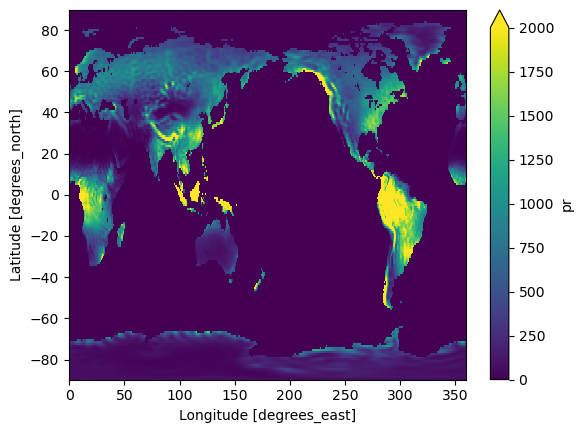

In [72]:
pr_monthly = pr_2.groupby('time.month').mean()
P_ann = pr_monthly.sum(dim='month')
P_ann.plot(vmin=0, vmax=2000)

In [73]:
MAT = tas.mean(dim='time')
MAP = (pr*60*60*24*365.25).mean(dim='time') 

In [74]:
winter_mask_NH = np.logical_or(pr.time.dt.month >= 10, pr.time.dt.month <= 3)  #Oct–Mar
winter_mask_SH = np.logical_and(pr.time.dt.month >= 4, pr.time.dt.month <= 9)  #Apr–Sep
#defining hemispheres by their position relative to the equator
is_NH = pr.lat >= 0
is_SH = pr.lat < 0

In [75]:
#use these variables to count months, they have a time dim = 120
#creating masks for each hemisphere - precip
pr_winter = xr.where(is_NH, pr.where(winter_mask_NH, pr), pr.where(winter_mask_SH, pr))
pr_summer = xr.where(is_NH, pr.where(~winter_mask_NH, pr), pr.where(~winter_mask_SH, pr))
#creating masks for each hemispheere - temp
tas_winter = xr.where(is_NH, tas.where(winter_mask_NH, tas), tas.where(winter_mask_SH, tas))
tas_summer = xr.where(is_NH, tas.where(~winter_mask_NH, tas), tas.where(~winter_mask_SH, tas))

In [76]:
#now get seasonal means for both precip and temp 
tas_winter_mean = tas_winter.mean(dim='time')
tas_summer_mean = tas_summer.mean(dim='time')
pr_winter_mean = pr_winter.mean(dim='time')
pr_summer_mean = pr_summer.mean(dim='time')

In [77]:
#DO NOT use these variables to count months, use them for broad criteria that doesn't depend on monthly data 
#defining winter precip 
P_winter = xr.where((tas_winter_mean > tas_summer_mean), pr_summer_mean, pr_winter_mean)
#defining summer precip
P_summer = xr.where((tas_winter_mean > tas_summer_mean), pr_winter_mean, pr_summer_mean)

In [78]:
months = np.arange(1, 13) #1 = Jan, 12 = Dec
high_sun_NH = np.logical_and(months>=4, months<=9) #april-september
high_sun_SH = np.logical_or(months>=10, months<=3) #october-march
high_sun_SH

array([ True,  True,  True, False, False, False, False, False, False,
        True,  True,  True])

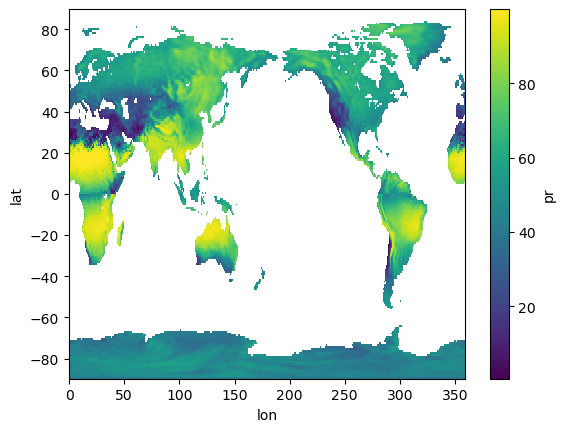

In [79]:
pr_NH = pr_monthly.where(lat >= 0)
pr_SH = pr_monthly.where(lat < 0)
#getting high sun months
pr_NH_var = pr_NH
pr_NH_high_sun = pr_NH_var.sel(month=high_sun_NH)
pr_SH_var = pr_SH
pr_SH_high_sun = pr_SH_var.sel(month=high_sun_SH)
#getting percentages of high sun month precip compared to total annual precip
pr_NH_high_sun_summed = pr_NH_high_sun.sum(dim=('month'))
pr_SH_high_sun_summed = pr_SH_high_sun.sum(dim=('month'))
P_NH = (pr_NH_high_sun_summed / P_ann) * 100
P_SH = (pr_SH_high_sun_summed / P_ann) * 100
#combining hemispheres
P = P_SH + P_NH
P.plot()

pr_NH = pr_monthly.where(lat >= 0)
pr_SH = pr_monthly.where(lat < 0)
#getting high sun months
pr_NH_high_sun = pr_NH[high_sun_NH]
pr_SH_high_sun = pr_SH[high_sun_SH]
#getting percentages of high sun month precip compared to total annual precip
pr_NH_high_sun_summed = pr_NH_high_sun.sum(dim=('month'))
pr_SH_high_sun_summed = pr_SH_high_sun.sum(dim=('month'))
P_NH = (pr_NH_high_sun_summed / P_ann) * 100
P_SH = (pr_SH_high_sun_summed / P_ann) * 100
#combining hemispheres
P = P_SH + P_NH
P.plot()

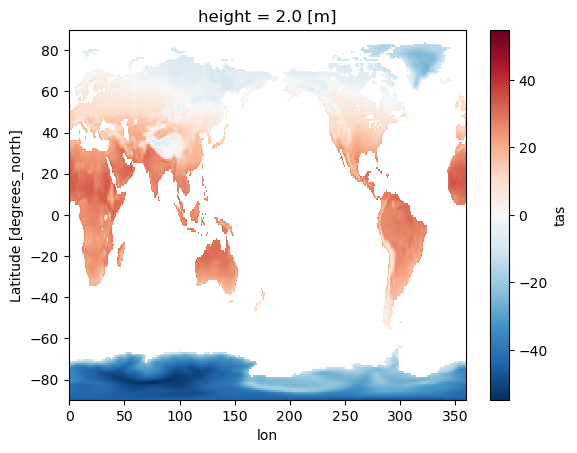

In [80]:
MAT_C = MAT - 273.15 #converting MAT to celsius because the aridity threshold formula uses celsius 
MAT_C.plot()

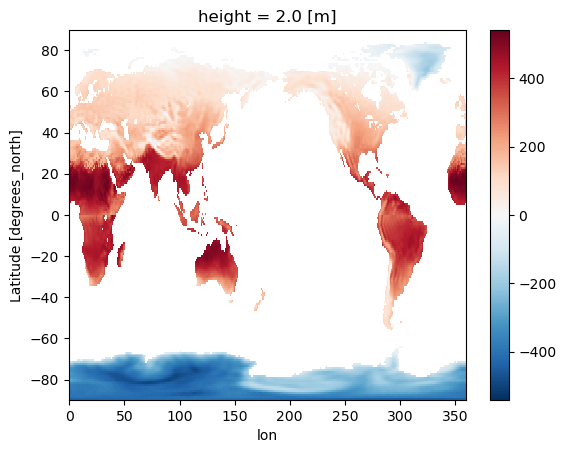

In [81]:
#align MAT_C and P dims
#P = P.reindex_like(MAT_C, method="nearest")

aridity_thresh = ((MAT_C - 10) * 10) + (3 * P)
aridity_thresh.plot()

In [82]:
Tcold = temperature_dataset_masked['tas'].sel(time=slice(start, end)).groupby("time.month").mean().min(dim='month')
Thot = temperature_dataset_masked['tas'].sel(time=slice(start, end)).groupby("time.month").mean().max(dim='month')

ARID (B)
==

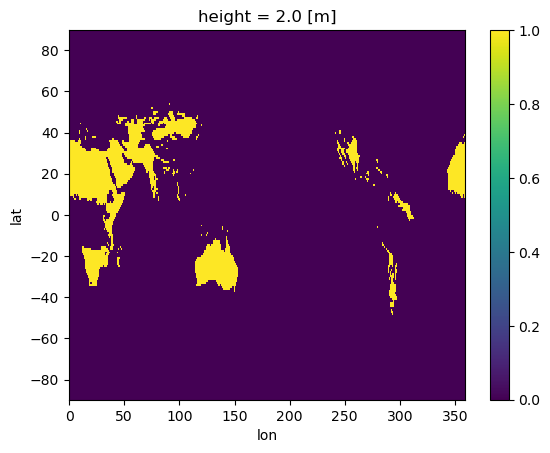

In [83]:
B = xr.where((P_ann<(2*aridity_thresh)), True, False)
B.plot()

In [84]:
B_area = (B*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
B_area

<xarray.DataArray ()>
array(3.13084014)
Coordinates:
    height   float64 2.0

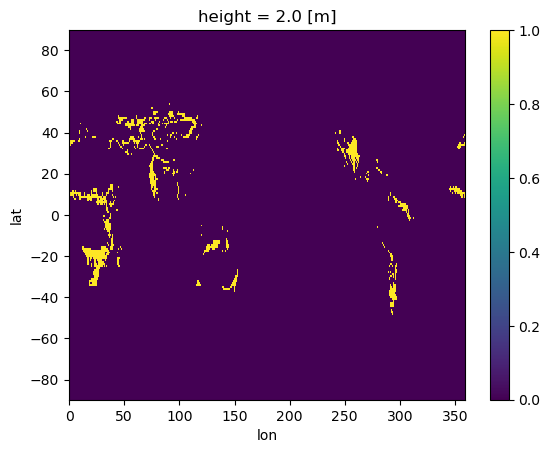

In [85]:
BS = xr.where(np.logical_and(P_ann<2*aridity_thresh, P_ann>aridity_thresh), True, False)
BS.plot()

In [86]:
BS_area = (BS*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
BS_area

<xarray.DataArray ()>
array(1.068254)
Coordinates:
    height   float64 2.0

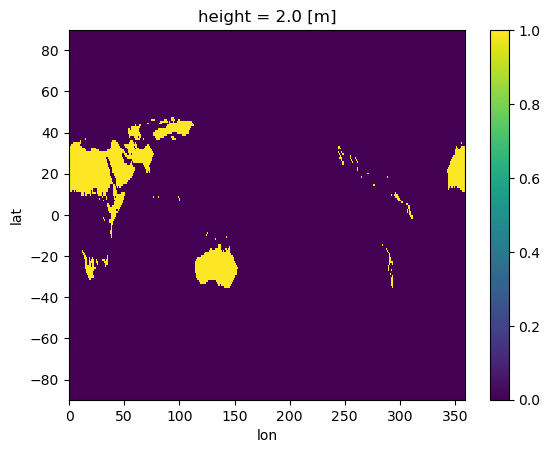

In [87]:
BW_1 = xr.where(np.logical_and(P_ann<=aridity_thresh, B), True, False)
BW = xr.where(np.logical_and(BW_1, ~BS), True, False)
BW.plot() 

In [88]:
BW_area = (BW*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
(BW_area + BS_area) - B_area

<xarray.DataArray ()>
array(0.)
Coordinates:
    height   float64 2.0

that area is very small, so we do not care lol

In [89]:
tas_1 = tas.sel(time=slice(start, end))
tas_2 = tas_1.groupby('time.month')
tas_monthly = tas_2.mean(dim='time')

crit = xr.where(tas_monthly > 283, True, False)
tas_crit = crit.sum(dim='month')

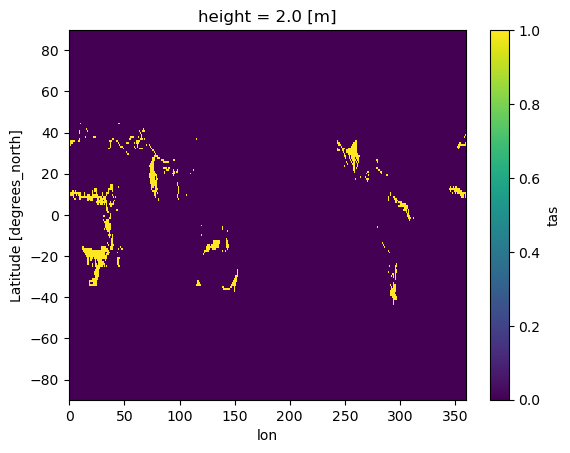

In [90]:
BSh = xr.where(np.logical_and((tas_crit>8), BS), True, False)
#BSh = xr.where(np.logical_and(BSh_1, ~BW), True, False)
BSh.plot()

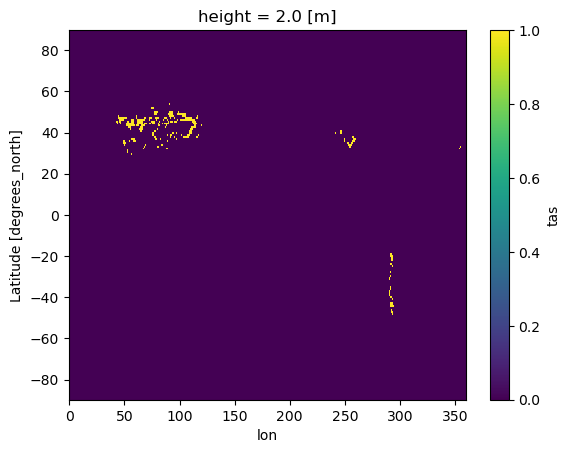

In [91]:
#BSk = xr.where(np.logical_and((tas_crit<=8), BS), True, False)
#BSk = xr.where(np.logical_and(BSk_1, B), True, False)
BSk = xr.where(np.logical_and(~BSh, BS), True, False)
BSk.plot()

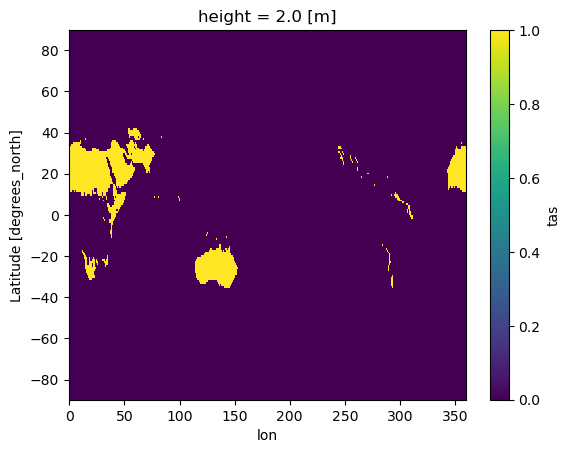

In [92]:
BWh = xr.where(np.logical_and((tas_crit>8), BW), True, False)
BWh.plot()

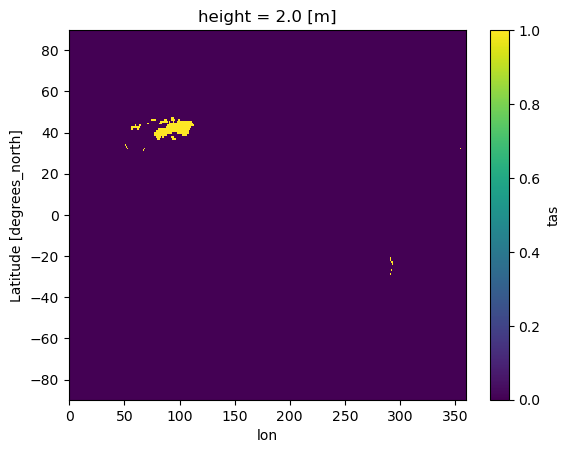

In [93]:
#BWk = xr.where(np.logical_and((tas_crit<=8), BW), True, False)
BWk = xr.where(np.logical_and(~BWh, BW), True, False)
BWk.plot()

In [94]:
BWh_area = (BWh*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
BWk_area = (BWk*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
BSh_area = (BSh*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
BSk_area = (BSk*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100

In [95]:
(BWh_area + BWk_area + BSh_area + BSk_area) - B_area

<xarray.DataArray ()>
array(2.32830644e-08)
Coordinates:
    height   float64 2.0

TROPICAL (A)
==

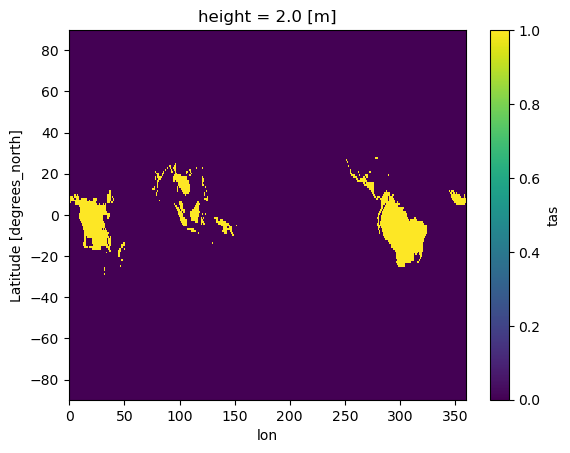

In [96]:
A_1 = xr.where((Tcold>(273.15+18)), True, False)
A = xr.where(np.logical_and(A_1, ~B), True, False)
A.plot()

In [97]:
Pdry =  pr_converted.sel(time=slice(start, end)).groupby("time.month").mean().min(dim='month')

In [98]:
Pmonth_1 = pr_converted.sel(time=slice(start, end))
Pmonth_2 = Pmonth_1.groupby('time.month')
Pmonth = Pmonth_2.mean(dim='time')

Ar_crit = xr.where(Pmonth>60, True, False)
Pmonth_crit = Ar_crit.sum(dim='month')

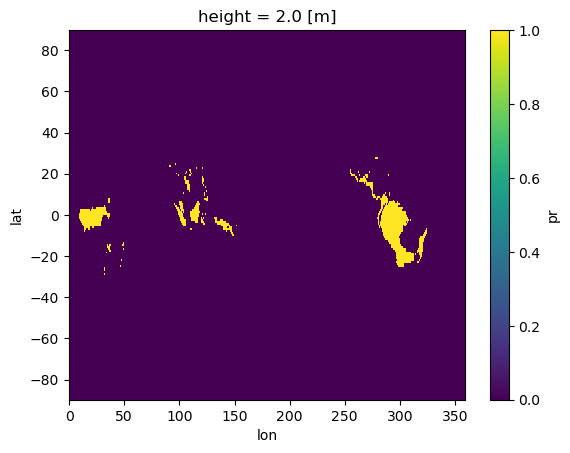

In [99]:
rainforest_crit = Pmonth_crit > 10
Ar = xr.where(np.logical_and(rainforest_crit, A), True, False)
Ar.plot()

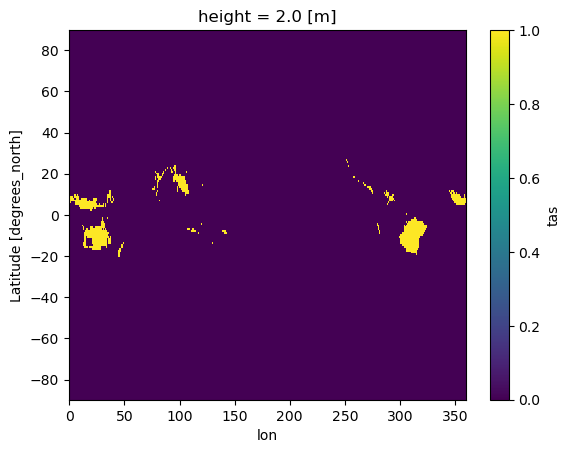

In [100]:
Aw_crit = (pr_winter < 60)
Pwint_crit = Aw_crit.sum(dim='time')
Aw_month_crit = Pwint_crit > 2

#creating Aw map
#Aw_1 = xr.where(np.logical_and(Aw_month_crit, A), True, False)
#Aw = xr.where(np.logical_and(Aw_1, ~Ar), True, False)
Aw = xr.where(np.logical_and(A, ~Ar), True, False)
Aw.plot()

In [101]:
Ar_area = (Ar*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
Aw_area = (Aw*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
A_area = (A*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100

(Ar_area + Aw_area) - A_area

<xarray.DataArray ()>
array(-2.32830644e-08)
Coordinates:
    height   float64 2.0

SUBTROPICAL (C)
==

In [102]:
tas_month_1 = tas.sel(time=slice(start, end))
tas_month_2 = tas_month_1.groupby('time.month')
tas_month = tas_month_2.mean(dim='time')

C_crit = xr.where(tas_month>283.15, True, False)
tas_month_crit = C_crit.sum(dim='month')

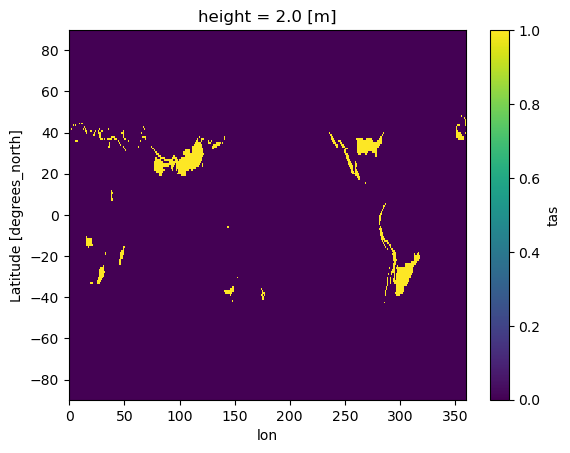

In [103]:
month_count_crit = xr.where(np.logical_and(tas_month_crit >= 8, tas_month_crit <= 12), True, False)
C_unmasked = xr.where(month_count_crit, True, False)
not_tropic_arid = xr.where(np.logical_and(~B, ~A), True, False) #extract variables from arid and tropical so they can become arrays 
C = xr.where(np.logical_and(month_count_crit, not_tropic_arid), True, False)
C.plot()

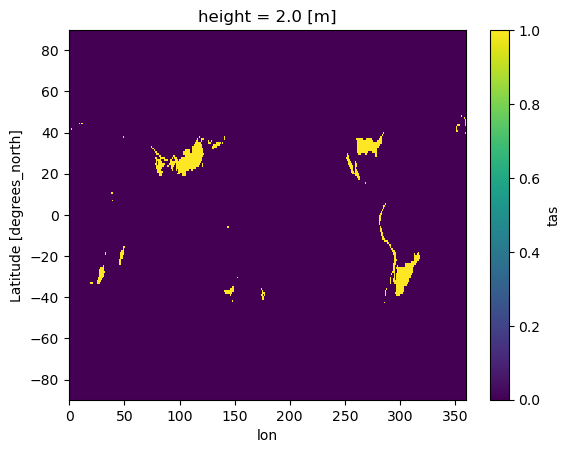

In [104]:
Cf = xr.where(np.logical_and(C, Pdry>30), True, False)
Cf.plot()

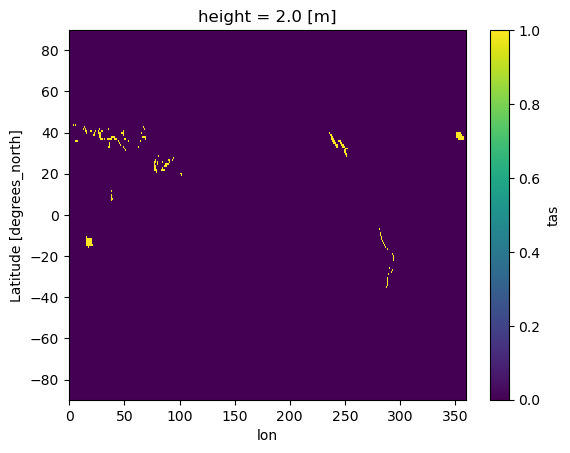

In [105]:
Cm = xr.where(np.logical_and(C, ~Cf), True, False)
Cm.plot()

In [106]:
C_area = (C*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
C_area

<xarray.DataArray ()>
array(0.92900563)
Coordinates:
    height   float64 2.0

In [107]:
Cm_area = (Cm*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
Cf_area = (Cf*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100

(Cf_area + Cm_area) - C_area

<xarray.DataArray ()>
array(6.98491931e-08)
Coordinates:
    height   float64 2.0

TEMPERATE (D)
==

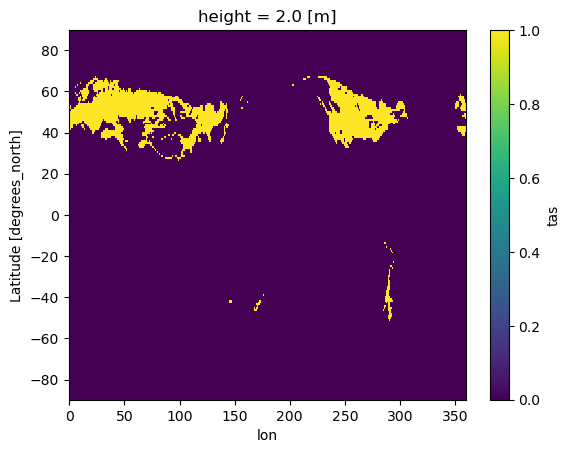

In [108]:
D_crit = xr.where(tas_month>283.15, True, False)
tas_month_crit = D_crit.sum(dim='month')

D_count_crit_1 = tas_month_crit >= 4
D_count_crit_2 = tas_month_crit <= 7
not_tropic_arid = xr.where(np.logical_and(~B, ~A), True, False)
D_1 = xr.where(np.logical_and(D_count_crit_1, D_count_crit_2), True, False)
D_2= xr.where(np.logical_and(D_1, not_tropic_arid), True, False)
D = xr.where(np.logical_and(D_2, ~C), True, False)
D.plot()

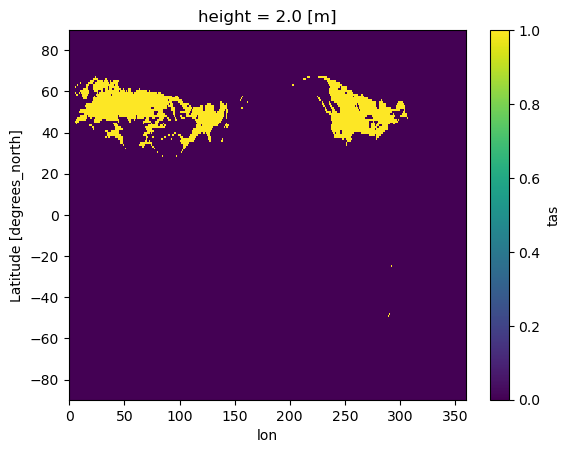

In [109]:
DC = xr.where(np.logical_and(Tcold < 273.15, D), True, False)
DC.plot()

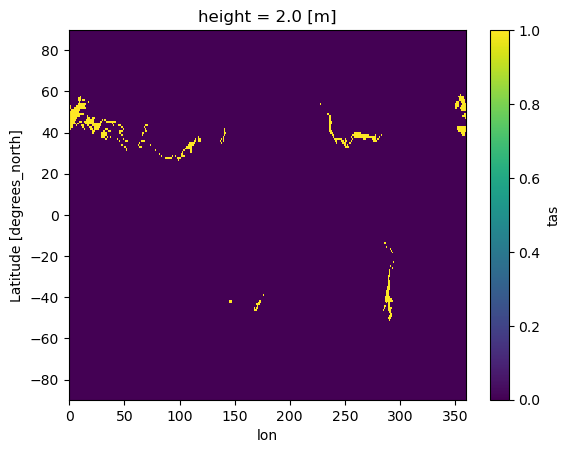

In [110]:
DO = xr.where(np.logical_and(D, Tcold>273.15), True, False)
DO.plot()

In [111]:
D_area = (D*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
DO_area = (DO*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
DC_area = (DC*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100

D_area - (DO_area + DC_area)

<xarray.DataArray ()>
array(-4.65661287e-08)
Coordinates:
    height   float64 2.0

again, extremely small, so doesn't matter

SUBPOLAR (E)
==

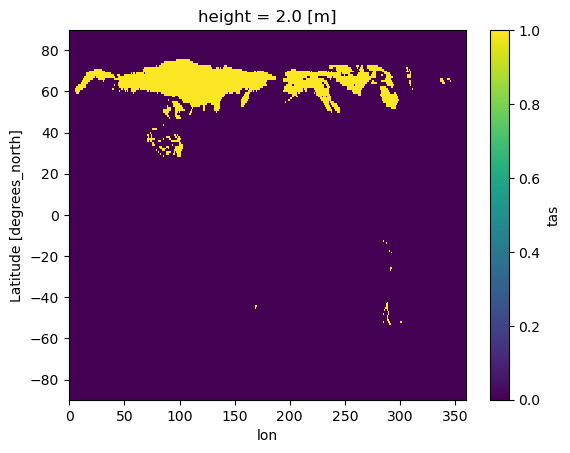

In [112]:
E_crit = xr.where(tas_month>283.15, True, False)
tas_month_crit = E_crit.sum(dim='month')

crit_1 = tas_month_crit >= 1
crit_2 = tas_month_crit <= 3
E_1 = xr.where(np.logical_and(crit_2, crit_1), True, False)
E_2 = xr.where(np.logical_and(not_tropic_arid, ~C), True, False)
E = xr.where(np.logical_and(E_1, E_2), True, False)
E.plot()

EC = xr.where(np.logical_and(E, (Tcold < 263.15)), True, False)
EC.plot()

EO = xr.where(np.logical_and(E, (Tcold > 263.15)), True, False)
EO.plot()

E_area = (E*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
EO_area = (EO*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
EC_area = (EC*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100

E_area - (EO_area + EC_area)

doesn't matter, very small

POLAR (F)
==

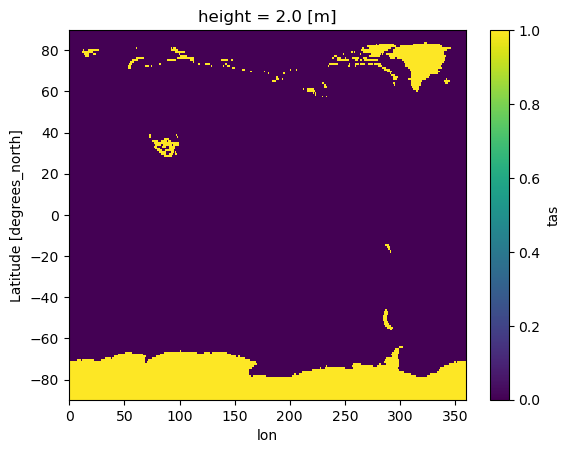

In [113]:
F_1 = xr.where(np.logical_and(Thot < 283.15, ~E), True, False)
F_2 = xr.where(np.logical_and(F_1, not_tropic_arid), True, False)
F = xr.where(np.logical_and(F_2, ~C), True, False)
F.plot()

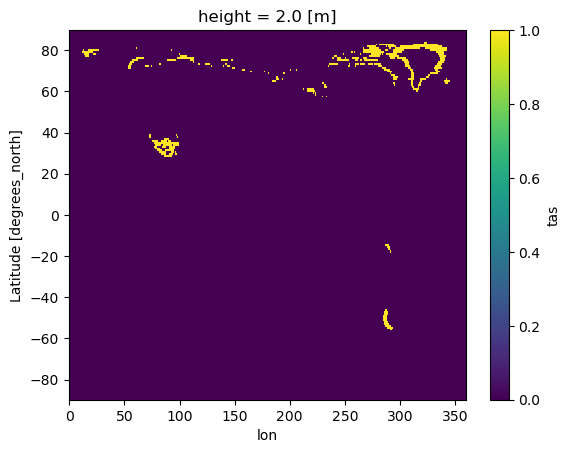

In [114]:
crit_1 = Thot > 273.15
crit_2 = Thot < 283.15
Ft_1 = xr.where(np.logical_and(crit_1, crit_2), True, False)
Ft = xr.where(np.logical_and(Ft_1, F), True, False)
Ft.plot()

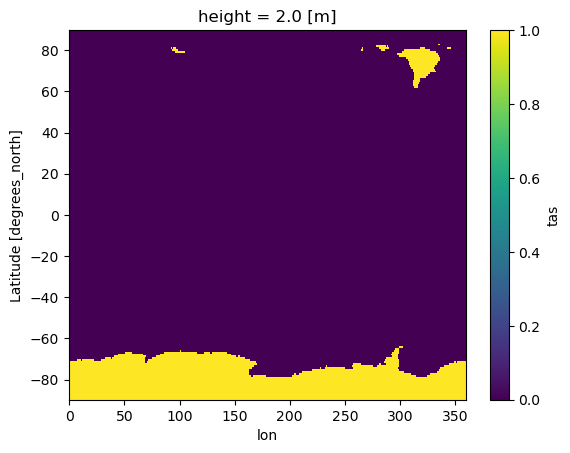

In [115]:
monthly_temp = temperature_dataset_masked['tas'].groupby("time.month").mean(dim="time")
monthly_temp_2 = monthly_temp.mean('month')
Fi_1 = xr.where(monthly_temp_2 < 273.15, True, False)
Fi_2 = xr.where(np.logical_and(Fi_1, F), True, False)
Fi = xr.where(np.logical_and(Fi_2, ~Ft), True, False)
Fi.plot()

In [116]:
F_area = (F*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
Fi_area = (Fi*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
Ft_area = (Ft*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100

F_area - (Ft_area + Fi_area)

<xarray.DataArray ()>
array(1.86264515e-07)
Coordinates:
    height   float64 2.0

made more things mutually exclusive, so now this small number does not matter

combine all these into a KTC dataset
==

In [117]:
ds = xr.Dataset()
ds['lat'] = B.lat
ds['lon'] = B.lon

In [118]:
ds['B'] = B
ds['B'].attrs= {'long_name' : 'arid'}

In [119]:
ds['BS'] = BS
ds['BS'].attrs= {'long_name' : 'semi-arid/steppe'}
ds['BW'] = BW
ds['BW'].attrs= {'long_name' : 'desert'}

ds['BSh'] = BSh
ds['BSh'].attrs= {'long_name' : 'semi-arid/steppe hot'}
ds['BWh'] = BWh
ds['BWh'].attrs= {'long_name' : 'desert hot'}
ds['BSk'] = BSk
ds['BSk'].attrs= {'long_name' : 'semi-arid/steppe cold'}
ds['BWk'] = BWk
ds['BWk'].attrs= {'long_name' : 'desert cold'}

In [120]:
ds['A'] = A
ds['A'].attrs= {'long_name' : 'tropical'}

ds['Ar'] = Ar
ds['Ar'].attrs= {'long_name' : 'rainforest'}
ds['Aw'] = Aw
ds['Aw'].attrs= {'long_name' : 'savannah'}

In [121]:
ds['C'] = C
ds['C'].attrs= {'long_name' : 'subtropical'}

ds['Cm'] = Cm
ds['Cm'].attrs= {'long_name' : 'w/ dry season'}
ds['Cf'] = Cf
ds['Cf'].attrs= {'long_name' : 'humid, w/o dry season'}

In [122]:
ds['D'] = D
ds['D'].attrs={'long_name' : 'temperate'}

ds['DC'] = DC
ds['DC'].attrs={'long_name' : 'temperate continental'}
ds['DO'] = DO
ds['DO'].attrs={'long_name' : 'temperate oceanic'}

In [123]:
ds['E'] = E
ds['E'].attrs={'long_name' : 'subpolar'}

#ds['EC'] = EC
#ds['EC'].attrs={'long_name' : 'subpolar continental'}
#ds['EO'] = EO
#ds['EO'].attrs={'long_name' : 'subpolar oceanic'}

In [124]:
ds['F'] = F
ds['F'].attrs={'long_name' : 'polar'}

ds['Ft'] = Ft
ds['Ft'].attrs={'long_name' : 'polar tundra'}
ds['Fi'] = Fi
ds['Fi'].attrs={'long_name' : 'polar ice cap'}

In [125]:
ds

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 384)
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Data variables: (12/20)
    B        (lat, lon) bool False False False False ... False False False False
    BS       (lat, lon) bool False False False False ... False False False False
    BW       (lat, lon) bool False False False False ... False False False False
    BSh      (lat, lon) bool False False False False ... False False False False
    BWh      (lat, lon) bool False False False False ... False False False False
    BSk      (lat, lon) bool False False False False ... False False False False
    ...       ...
    DC       (lat, lon) bool False False False False ... False False False False
    DO       (lat, lon) bool False False False False ... False False False False
    E        (lat, lon) bool False False False False ... False False False False
    F        (lat, lon) bool True True True True ... False False False False
    Ft       (lat, lon) bool False False False False ... False False False False
    Fi       (lat, lon) bool True True True True ... False False False False

In [127]:
#ds.to_netcdf(path='/Users/jaybr/OneDrive/Desktop/RESEARCH/MPI-HR_KTC_future_dataset_SSP2-4.5', mode='w')